In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from operator import attrgetter
import requests
import warnings
warnings.filterwarnings("ignore")
from urllib.parse import urlencode
%matplotlib inline

In [2]:
customers_url = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_url = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items_url = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [3]:
def get_yandex_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
customers = pd.read_csv(get_yandex_download_url(customers_url))
orders =  pd.read_csv(get_yandex_download_url(orders_url), parse_dates=[3,4,5,6,7])
items = pd.read_csv(get_yandex_download_url(items_url))

In [5]:
customers.head() #таблица с уникальными идентификаторами пользователей

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
customers.customer_id.nunique() #количество уникальных заказов

99441

In [7]:
customers.customer_unique_id.nunique() #количество уникальных пользователей

96096

In [8]:
orders.head() #таблица заказов

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
orders.order_id.nunique()

99441

In [10]:
orders.order_status.value_counts() #типы и количество статусов заказов

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [11]:
orders.isna().sum() 
#количество пустых значений в строках (160 без факта оплаты, 1783 не были переданы в доставку, 2965 не доставлены)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
orders.order_purchase_timestamp.min() #дата первой покупки

Timestamp('2016-09-04 21:15:19')

In [13]:
orders.order_approved_at.max() #дата последней покупки

Timestamp('2018-09-03 17:40:06')

In [14]:
items.order_id.nunique() #количество чеков меньше, чем в предыдущих таблицах

98666

In [15]:
items.product_id.nunique() #количество уникальных товаров

32951

#### 1. Узнаем сколько пользователей, которые совершили покупку только один раз

В соответствии с таблицей orders есть 7 уникальных статусов заказов. В анализе для данного задания я учла заказы только со статусом delivered, так как факт оплаты или отгрузки товара не отражает реальный факт перехода права собственности. Заказы могут быть отменены в процессе доставки.

In [16]:
df_1 = customers.merge(orders)

In [17]:
df_1.query("order_status == 'delivered'").groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).query("order_id == 1").shape

(90557, 2)

#### 90557 пользователей совершили покупку только один раз

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (выведем детализацию по причинам)?

In [18]:
orders.order_status.value_counts().to_frame() #выведем какие есть статусы и их количество

,order_status
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [19]:
orders.query("order_status != 'delivered'").shape[0]

2963

Всего 2963 заказов находятся в процессе доставки, либо не доставлены или отменены

In [20]:
orders.query("order_approved_at == 'NaT'").order_status.value_counts().to_frame()

,order_status
canceled,141
delivered,14
created,5


141 заказов из отмененных были не оплачены. 5 созданы, но также не оплачены. 14 заказов были доставлены без подтверждения оплаты.

In [21]:
orders.query("order_status == 'canceled' & order_approved_at != 'NaT' & order_delivered_carrier_date == 'NaT'").shape[0]

409

409 заказов из отмененных были с подтверждением оплаты, но не переданы в логистическую службу

In [13]:
orders.query("order_status == 'canceled' & order_approved_at != 'NaT' & order_delivered_carrier_date != 'NaT'& order_delivered_customer_date == 'NaT'")\
        .shape[0]

69

69 заказов со статусом canceled были переданы в логистическую службу, но не доставлены

In [14]:
orders.query("order_status == 'canceled' & order_approved_at != 'NaT' & order_delivered_carrier_date != 'NaT'& order_delivered_customer_date != 'NaT'")\
      .shape[0]

6

#### 6 заказов со статусом canceled были доставлены, что не входит в общее количество заказов со статусом delivered. Возможно это сбой.

In [24]:
orders.query("order_status == 'unavailable'").shape[0]

609

609 заказов со статусом unavailable были оплачены, но не переданы в доставку

In [25]:
orders.order_delivered_customer_date.isna().sum()

2965

#### Количество заказов без даты доставки и количество заказов без статуса delivered не совпадают. Выведем детализацию по заказам без даты доставки.

In [26]:
orders.query("order_delivered_customer_date == 'NaT'").order_status.value_counts().to_frame()

,order_status
shipped,1107
canceled,619
unavailable,609
invoiced,314
processing,301
delivered,8
created,5
approved,2


#### 8 заказов без даты доставки имеют статус delivered. Возможно это сбой, как и в случае с доставленными заказами со статусом canceled.

#### Таким образом, если в общую сумму заказов без статуса delivered включить еще 8 заказов без даты доставки, но со статусом delivered и исключить 6 доставленных заказов со статусом canceled, значения совпадут (2963+8-6 = 2965).

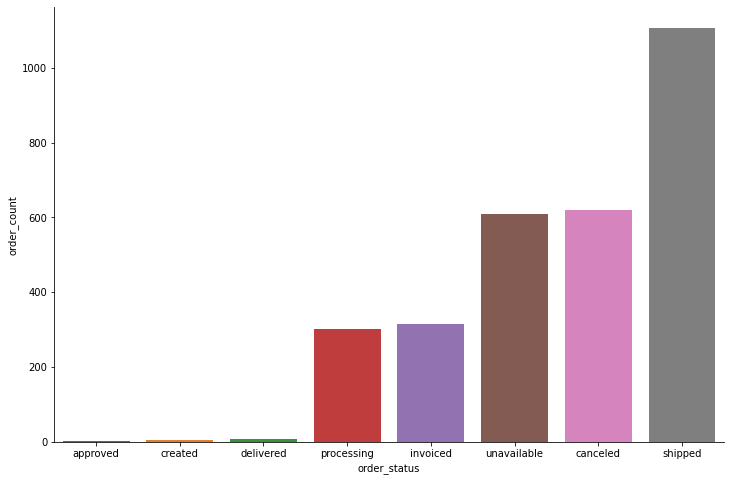

In [27]:
ax = orders.query("order_delivered_customer_date == 'NaT'")\
           .groupby('order_status', as_index=False).agg({'order_id': 'count'})\
           .sort_values('order_id').rename(columns={"order_id": "order_count"})
fig = plt.figure(figsize=(12,8))
sns.barplot(x=ax.order_status,y=ax.order_count,data=ax)
sns.despine()

#### Посчитаем сколько заказов в месяц в среднем не доставляется по разным причинам

In [16]:
orders.query("order_delivered_customer_date == 'NaT'").order_status.value_counts().to_frame()

,order_status
shipped,1107
canceled,619
unavailable,609
invoiced,314
processing,301
delivered,8
created,5
approved,2


#### Заказы со статусами created, approved, invoiced, processing, shipped - и не должны иметь время доставки, поэтому их не рассматриваем. Интересуют статусы: delivered, canceled, unavailable. Рассмотрим их.

In [17]:
df_2 = orders.query("order_delivered_customer_date == 'NaT'")

In [18]:
df_2['order_status']= df_2.order_status.replace('delivered','status_fault')

In [19]:
df_2.order_estimated_delivery_date = df_2.order_estimated_delivery_date.dt.strftime('%Y-%m')

In [20]:
df_2.query("order_status == 'canceled' | order_status == 'unavailable'")\
    .groupby(['order_status','order_estimated_delivery_date'], as_index=False).agg({'order_id':'count'})\
    .groupby('order_status', as_index=False).agg({'order_id':'mean'}).sort_values('order_id', ascending=False).round()
#среднее количество заказов, которые не доставляются по разным причинам

,order_status,order_id
1,unavailable,29.0
0,canceled,24.0


#### По причине отмены в среднем не доставляется 24 заказа в месяц, по причине недоступности товаров в среднем не доставляется 29 заказов в месяц

### 3. По каждому товару определим, в какой день недели товар чаще всего покупается

In [8]:
df_3 = orders.merge(items[['product_id', 'order_id']], how='left', on='order_id')
#оставим все заказы и посмотрим в какой день недели каждый товар вызывает интерес

In [9]:
df_3['weekday'] = df_3.order_purchase_timestamp.dt.day_name()

In [34]:
df_3_1 = df_3.groupby(['product_id', 'weekday'], as_index=False).agg({'order_id':'count'})\
             .sort_values('order_id', ascending=False)
df_3_1.head() #определяем количество покупок по дням недели

,product_id,weekday,order_id
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


In [35]:
df_3_1.drop_duplicates(subset='product_id') #удаляем дубликаты и определяем, в какой день недели товар чаще всего покупается

,product_id,weekday,order_id
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
24030,6432d844f2be41bb6f2fd279e23415da,Friday,1
24009,6421ae053bb80dff3ceae1f217f54ed4,Monday,1
24010,642247ccf62585635cefa1bf09f59b94,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1


Количество строк совпадает с уникальным количеством product_id в таблице items - 32951

In [36]:
df_3.groupby('weekday', as_index=False).agg({'order_id': 'count'}).sort_values('order_id', ascending=False)

,weekday,order_id
1,Monday,18521
5,Tuesday,18369
6,Wednesday,17727
4,Thursday,16919
0,Friday,16159
3,Sunday,13488
2,Saturday,12242


Также дополнительно определили, что чаще всего заказы оформляются по понедельникам

In [37]:
df_3_1.pivot(index='product_id', columns='weekday', values='order_id').reset_index()

weekday,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0
4,000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,NaN,NaN,1.0,1.0,NaN,NaN,NaN
32947,fff81cc3158d2725c0655ab9ba0f712c,NaN,1.0,NaN,NaN,NaN,NaN,NaN
32948,fff9553ac224cec9d15d49f5a263411f,1.0,NaN,NaN,NaN,NaN,NaN,NaN
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,NaN,NaN,1.0,1.0,2.0,NaN


Если вывести таблицу в таком виде, то видно, например, по строке 32946, что товар покупался одинаковое количество раз в субботу и воскресенье

In [38]:
df_3_1.drop_duplicates(subset='product_id').query("product_id == 'fff6177642830a9a94a0f2cba5e476d1'")

,product_id,weekday,order_id
61222,fff6177642830a9a94a0f2cba5e476d1,Sunday,1


Однако, в конечной таблице выводится только воскресенье

In [40]:
df_3_1.query("product_id == 'ffd4bf4306745865e5692f69bd237893'") #еще одна проверка

,product_id,weekday,order_id
61191,ffd4bf4306745865e5692f69bd237893,Sunday,2
61190,ffd4bf4306745865e5692f69bd237893,Saturday,2
61188,ffd4bf4306745865e5692f69bd237893,Friday,2
61189,ffd4bf4306745865e5692f69bd237893,Monday,1
61192,ffd4bf4306745865e5692f69bd237893,Wednesday,1


In [39]:
df_3_1.drop_duplicates(subset='product_id').query("product_id == 'ffd4bf4306745865e5692f69bd237893'") #вывод в конечной талице

,product_id,weekday,order_id
61191,ffd4bf4306745865e5692f69bd237893,Sunday,2


#### Таким образом, если у товара одинаковое количество покупок в разные дни, то выводится день ближайший к началу недели. Такой вывод искажает выбор дня с наибольшим количеством покупок.  Но выбор дня для продуктов с небольшим количеством покупок может быть не имеет существенной роли.

In [41]:
df_3_1.drop_duplicates(subset='product_id').order_id.describe()

count    32951.000000
mean         1.673242
std          2.281261
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         93.000000
Name: order_id, dtype: float64

In [42]:
df_3_1.drop_duplicates(subset='product_id').query("order_id > 2") 
#количество товаров с покупкой > 2 в день с наибольшим количеством заказов составляет приблизительно 12%

,product_id,weekday,order_id
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
6193,195a72beccf48da20d71e2d7530b470a,Thursday,3
7754,1fce7b244f4a45431713165a869f5f32,Saturday,3
1153,0554df77f3ed2e36e06c60eb65dc357a,Tuesday,3
58892,f6ce2f79a280fa3c1ddc114d34ab273d,Friday,3


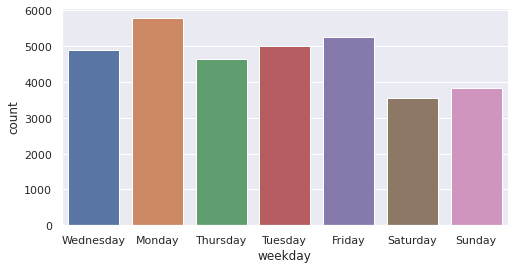

In [43]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(x = df_3_1.drop_duplicates(subset='product_id').weekday)
plt.show() #визуализация конечной таблицы 

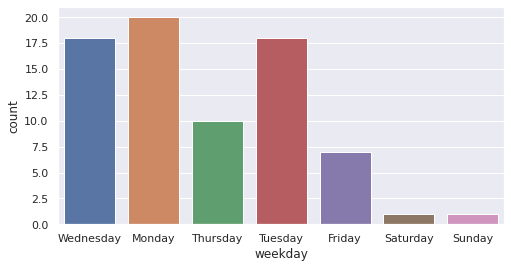

In [44]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(x = df_3_1.drop_duplicates(subset='product_id').query("order_id >= 20").weekday)
plt.show() #визуализация таблицы с сортировкой, где количество продаж > 20

Так как товаров с большим количеством продаж мало, выбор дня для товаров с маленьким количеством продаж влияет на распределение.

#### Определю в какой день чаще всего совершаются покупки по доставленным товарам

In [10]:
df_3_delivered = df_3.query("order_status == 'delivered' & order_approved_at != 'NaT'") #оставляем только купленные товары

In [11]:
df_3_delivered['weekday'] = df_3.order_purchase_timestamp.dt.day_name()

In [12]:
df_3_delivered = df_3_delivered.groupby(['product_id', 'weekday'], as_index=False)\
                               .agg({'order_id':'count'}).sort_values('order_id', ascending=False)
df_3_delivered #определяем количество покупок по дням недели

,product_id,weekday,order_id
15594,422879e10f46682990de24d770e7f83d,Wednesday,93
35745,99a4788cb24856965c36a24e339b6058,Monday,91
40177,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40178,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
40173,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,83
...,...,...,...
23489,64187b994e1b15e6a59a6f72688fbea8,Friday,1
23490,64187b994e1b15e6a59a6f72688fbea8,Thursday,1
23491,641a45900528e8324c4848dda4e0a3fa,Monday,1
23492,641a45900528e8324c4848dda4e0a3fa,Saturday,1


In [48]:
df_3_delivered.drop_duplicates(subset='product_id')

,product_id,weekday,order_id
15594,422879e10f46682990de24d770e7f83d,Wednesday,93
35745,99a4788cb24856965c36a24e339b6058,Monday,91
40177,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19707,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12742,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23485,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23487,641444946fe3a839d726c32804cd1aff,Tuesday,1
23488,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23489,64187b994e1b15e6a59a6f72688fbea8,Friday,1


In [49]:
df_3_delivered.query("order_id > 2").drop_duplicates(subset='product_id')

,product_id,weekday,order_id
15594,422879e10f46682990de24d770e7f83d,Wednesday,93
35745,99a4788cb24856965c36a24e339b6058,Monday,91
40177,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19707,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12742,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
1941,0878b8484ae10e2ef355fac0690fabe7,Monday,3
55207,ec72556b5da399d24fe06338e816a9ac,Wednesday,3
2064,08fb1fed44ecc852b3ab9363b00d1c03,Thursday,3
57669,f6e0b7ccc34e4decc1b855f8da06a5fc,Monday,3


In [50]:
df_3_delivered.groupby('weekday', as_index=False).agg({'order_id': 'count'}).sort_values('order_id', ascending=False)

,weekday,order_id
1,Monday,9410
5,Tuesday,9286
6,Wednesday,9279
4,Thursday,8785
0,Friday,8607
3,Sunday,7558
2,Saturday,7019


#### 4.Посчитаем сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [51]:
df_4 = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [52]:
df_4.customer_unique_id.nunique() #количество уникальных пользователей

96096

In [53]:
df_4_1 = df_4.query("order_status == 'delivered' & order_approved_at != 'NaT'")\
             .groupby('customer_unique_id', as_index=False)\
             .agg({'order_id':'count'})
df_4_1
#уникальные пользователи,совершившие покупку и количество их заказов

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,1
93341,fffea47cd6d3cc0a88bd621562a9d061,1
93342,ffff371b4d645b6ecea244b27531430a,1
93343,ffff5962728ec6157033ef9805bacc48,1


In [54]:
df_4_1.order_id.describe()

count    93345.000000
mean         1.033414
std          0.209088
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: order_id, dtype: float64

In [55]:
df_4_1.query("order_id > 1")

,customer_unique_id,order_id
104,004288347e5e88a27ded2bb23747066c,2
243,00a39521eb40f7012db50455bf083460,2
305,00cc12a6d8b578b8ebd21ea4e2ae8b27,2
404,011575986092c30523ecb71ff10cb473,2
419,011b4adcd54683b480c4d841250a987f,2
...,...,...
92978,ff03923ad1eb9e32304deb7f9b2a45c9,2
93072,ff44401d0d8f5b9c54a47374eb48c1b8,2
93174,ff8892f7c26aa0446da53d01b18df463,2
93192,ff922bdd6bafcdf99cb90d7f39cea5b3,3


#### Как видно, пользователей, которые совершили больше одной покупки за все время совсем мало - 3% от общего числа. Если посчитать среднюю по неделям для каждого пользователя, то получатся очень маленькие значения.

In [56]:
df_4['month'] = df_4.order_purchase_timestamp.dt.strftime('%Y-%m')

In [57]:
df_4['week'] = (df_4['order_purchase_timestamp'].dt.daysinmonth) / 7 
#количество недель по месяцам

In [58]:
df_4_2 = df_4.query("order_status == 'delivered' & order_approved_at != 'NaT'")\
             .groupby(['month', 'customer_unique_id'], as_index=False).agg({'order_id':'count'})\
             .rename(columns = {'order_id':'orders_by_month'})
df_4_2 #группировка по уникальным пользователям, совершившим покупку и месяцам их покупок

,month,customer_unique_id,orders_by_month
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1
1,2016-10,0032c76b20340da25249092a268ce66c,1
2,2016-10,01f156677184504063bd19739f924af1,1
3,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,1
4,2016-10,06bdfbbe1857c3c925ec81abfb1c9666,1
...,...,...,...
95175,2018-08,ffc39051848c3ef2be36d1513aa3ad17,1
95176,2018-08,ffc4e1cd8aa220763480d0a18157c45d,1
95177,2018-08,ffe204b1bb8026741b839085b2fd10f2,1
95178,2018-08,ffec490ab531184a483efe2eedd68908,1


In [59]:
df_4_2['week'] = df_4.week

In [60]:
df_4_2 = df_4_2.assign(order_by_week = df_4_2.orders_by_month / df_4_2.week) #рассчет среднего
df_4_2.head()

,month,customer_unique_id,orders_by_month,week,order_by_week
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.428571,0.225806
1,2016-10,0032c76b20340da25249092a268ce66c,1,4.428571,0.225806
2,2016-10,01f156677184504063bd19739f924af1,1,4.428571,0.225806
3,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,1,4.285714,0.233333
4,2016-10,06bdfbbe1857c3c925ec81abfb1c9666,1,4.000000,0.250000


In [61]:
df_4_2.order_by_week.max() #максимальное значение среднего

1.3548387096774193

Количество уникальных пользователей не совпадает с конечным выводом, так как есть пользователи, совершившие покупку в разные месяцы либо отменившие свой заказ

In [62]:
df_4_2.groupby('customer_unique_id', as_index=False).agg({'order_by_week':'mean'}) 
#подсчет среднего по всем неделям для каждого пользователя

,customer_unique_id,order_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,0.250000
4,0004aac84e0df4da2b147fca70cf8255,0.233333
...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,0.225806
93341,fffea47cd6d3cc0a88bd621562a9d061,0.225806
93342,ffff371b4d645b6ecea244b27531430a,0.225806
93343,ffff5962728ec6157033ef9805bacc48,0.225806


In [63]:
df_4_2.groupby('customer_unique_id', as_index=False).agg({'order_by_week':'mean'}).order_by_week.max()
#максимальное среднее

1.3548387096774193

Как и предполагалось, получились очень маленькие значения. Посмотрим на среднее пользователя с наибольшим количеством покупок.

In [64]:
df_4_2.query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'") #пользователь с наибольшим количеством покупок

,month,customer_unique_id,orders_by_month,week,order_by_week
12588,2017-06,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.428571,0.225806
16060,2017-07,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.451613
20055,2017-08,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.285714,0.233333
24073,2017-09,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.428571,0.225806
28357,2017-10,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.451613
34352,2017-11,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.285714,0.233333
73713,2018-05,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.285714,0.466667
86119,2018-07,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.451613
92329,2018-08,8d50f5eadf50201ccdcedfb9e2ac8455,3,4.428571,0.677419


In [65]:
df_4_2.groupby('customer_unique_id', as_index=False).agg({'order_by_week':'mean'})\
      .query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'")
#его общее среднее

,customer_unique_id,order_by_week
51426,8d50f5eadf50201ccdcedfb9e2ac8455,0.379689


In [66]:
#так как его среднее меньше максимального среднего, посмотрим на пользователей со средним больше единицы
df_4_2.groupby('customer_unique_id', as_index=False).agg({'order_by_week':'mean'}).query("order_by_week > 1")

,customer_unique_id,order_by_week
6964,12f5d6e1cbf93dafd9dcc19095df0b3d,1.354839


In [67]:
df_4_2.query("customer_unique_id == '12f5d6e1cbf93dafd9dcc19095df0b3d'") 
#пользователь с наибольшим средним значением совершил 6 покупок за один месяц

,month,customer_unique_id,orders_by_month,week,order_by_week
326,2017-01,12f5d6e1cbf93dafd9dcc19095df0b3d,6,4.428571,1.354839


In [68]:
df_4_2.groupby('customer_unique_id', as_index=False).agg({'order_by_week':'count'}).query("order_by_week > 2")
#пользователи, у которых больше двух покупок в разные месяцы (в order_by_week количество значений)

,customer_unique_id,order_by_week
1498,041caba6a63ace5818387698ea85cdb2,3
3240,08c07c761592a71b85136aa4fe76a6f4,3
6918,12d8b5ed661190a3a08183644dfc504d,4
7149,1373e04979cfa0fb2092909abbd57f25,3
8877,182053495bc94c2f41090ce8c41be266,3
...,...,...
87873,f0e310a6839dce9de1638e0fe5ab282a,6
87909,f0fd988c7c2a4cba167138a8adada6ca,3
90742,f8bc1d81f395f6239a2a5ab1b9edf1ab,3
92805,fe81bb32c243a86b2f86fbf053fe6140,3


In [69]:
df_4_2.query("orders_by_month >= 2")
#пользователи, у которых больше двух покупок в месяц 

,month,customer_unique_id,orders_by_month,week,order_by_week
14,2016-10,0ecf7f65b5ff3b9e61b637e59f495e0a,2,4.428571,0.451613
126,2016-10,7a176e5d88c7acb6000a055e008c055d,2,4.285714,0.466667
253,2016-10,f7b62c75467e8ce080b201667cbbc274,2,4.285714,0.466667
326,2017-01,12f5d6e1cbf93dafd9dcc19095df0b3d,6,4.428571,1.354839
359,2017-01,1d2435aa3b858d45c707c9fc25e18779,2,4.285714,0.466667
...,...,...,...,...,...
93981,2018-08,cf56ccfd32ac8a510501a6fa69972c74,2,4.428571,0.451613
94160,2018-08,d649357bd5b1b116bf9662f41259db37,2,4.428571,0.451613
94517,2018-08,e53fd5575f1418397aae732c5755b6fc,2,4.428571,0.451613
94562,2018-08,e6f7ddad5d0159e391e27db652c17246,2,4.428571,0.451613


In [1]:
#Стоит ли считать среднее только для 3х процентов пользователей с количеством покупок > 1? Что конкретно требуется выяснить? 
#Возвращаются ли пользователи совершать покупки к конкретным товарам? 

#### 5. Проведем когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц.

In [21]:
df_5 = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [22]:
df_5 = df_5.query("order_status == 'delivered' & order_approved_at != 'NaT'")

In [23]:
#преобразование колонок по месяцу покупки 
#мы хотим оценить процент возврата пользователей

In [24]:
df_5['order_month'] = df_5.order_approved_at.dt.strftime('%Y-%m') #дата покупки

In [25]:
df_5["first_order"] = df_5.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.strftime('%Y-%m') 
#дата первой покупки пользователя

In [26]:
df_5_p = df_5.groupby(["first_order", "order_month"]).agg({"customer_unique_id": "nunique"})\
             .rename(columns={'customer_unique_id': 'total_customers'})
df_5_p #таблица без reset_index

total_customers
first_order order_month                 
2016-09     2016-09                    1
2016-10     2016-10                  262
            2017-04                    1
            2017-07                    1
            2017-09                    1
...                                  ...
2018-06     2018-07                   23
            2018-08                   16
2018-07     2018-07                 5846
            2018-08                   30
2018-08     2018-08                 6290

[219 rows x 1 columns]

In [27]:
df_5 = df_5.groupby(["first_order", "order_month"], as_index=False).agg({"customer_unique_id": "nunique"})\
           .rename(columns={'customer_unique_id': 'total_customers'})
df_5

,first_order,order_month,total_customers
0,2016-09,2016-09,1
1,2016-10,2016-10,262
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1
...,...,...,...
214,2018-06,2018-07,23
215,2018-06,2018-08,16
216,2018-07,2018-07,5846
217,2018-07,2018-08,30


In [28]:
df_5.first_order = pd.to_datetime(df_5.first_order).dt.to_period("m")
df_5.order_month = pd.to_datetime(df_5.order_month).dt.to_period("m")

In [29]:
df_5['ret'] = (df_5['order_month'] - df_5['first_order']).apply(attrgetter("n")) 
#считаем разницу месяцев с первой покупки до следующего заказа 

In [30]:
retention = df_5.query("'2017-01' <= first_order <= '2017-12'")\
                .pivot(index='first_order', columns = 'ret', values = 'total_customers')
retention

ret,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,683.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1612.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN
2017-04,2232.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3453.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,10.0,12.0,6.0,2.0,6.0,7.0,NaN,NaN,NaN
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN
2017-07,3709.0,20.0,12.0,7.0,13.0,7.0,12.0,4.0,7.0,9.0,8.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN
2017-08,4081.0,28.0,15.0,11.0,15.0,21.0,11.0,11.0,5.0,7.0,10.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4025.0,27.0,20.0,13.0,17.0,11.0,9.0,9.0,12.0,7.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
retention = retention.div(retention.iloc[:,0], axis = 0).mul(100).round(2) #перевожу в процентный вид
retention
#по столбцу с индексом 2 (третий месяц) видно, что самый высокий показатель в 2017-09 (0.50)

ret,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.44,0.29,0.15,0.44,0.15,0.44,0.15,0.15,NaN,0.29,0.29,0.73,0.44,0.15,0.15,0.29,0.44,0.15
2017-02,100.0,0.19,0.25,0.19,0.43,0.12,0.25,0.19,0.06,0.19,0.12,0.31,0.12,0.19,0.12,0.06,0.06,0.19,NaN
2017-03,100.0,0.44,0.36,0.36,0.36,0.16,0.16,0.32,0.28,0.12,0.36,0.12,0.20,0.12,0.16,0.24,0.08,0.12,NaN
2017-04,100.0,0.63,0.22,0.18,0.22,0.27,0.36,0.27,0.36,0.18,0.22,0.09,0.04,0.04,0.09,0.09,0.13,NaN,NaN
2017-05,100.0,0.52,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,0.29,0.35,0.17,0.06,0.17,0.20,NaN,NaN,NaN
2017-06,100.0,0.49,0.39,0.43,0.30,0.36,0.36,0.23,0.13,0.20,0.30,0.39,0.16,0.16,0.23,NaN,NaN,NaN,NaN
2017-07,100.0,0.54,0.32,0.19,0.35,0.19,0.32,0.11,0.19,0.24,0.22,0.30,0.13,0.24,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.69,0.37,0.27,0.37,0.51,0.27,0.27,0.12,0.17,0.25,0.17,0.15,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.67,0.50,0.32,0.42,0.27,0.22,0.22,0.30,0.17,0.25,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
round(retention.div(retention.iloc[:,0], axis = 0).mul(100), 2)[2].idxmax()

Period('2017-09', 'M')

<AxesSubplot:title={'center':'Cohorts: Retention Rate'}, xlabel='ret', ylabel='first_order'>

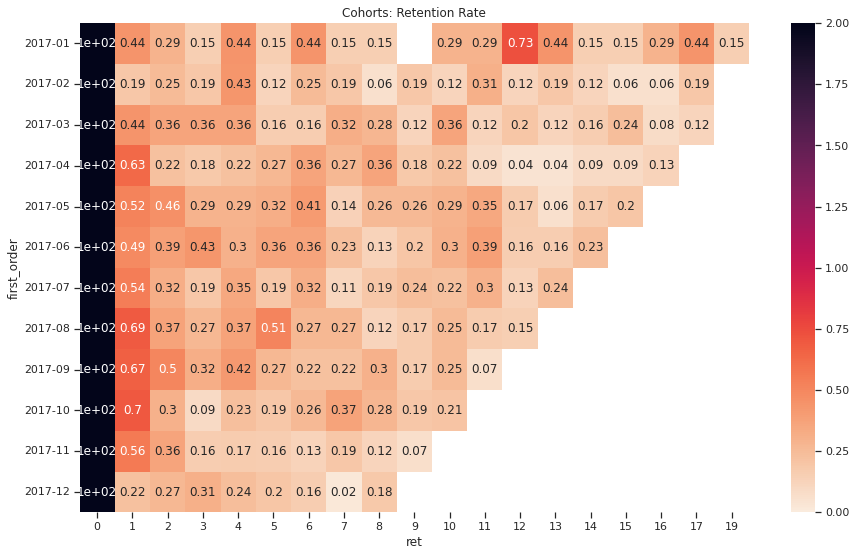

In [32]:
cmap = sns.cm.rocket_r
sns.set(style='ticks')
plt.figure(figsize=(15, 9))
plt.xlabel('Cohorts')
plt.title('Cohorts: Retention Rate')
sns.heatmap(retention, annot=True, cmap=cmap, vmin=0, vmax=2, center= 1)

#### 6. Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию

In [15]:
df_6 = customers.merge(orders, on='customer_id')
df_6 = df_6.merge(items)[['customer_unique_id', 'price', 'order_approved_at', 'order_id', 'product_id' ,'order_status']]

In [16]:
df_6 = df_6.query("order_status == 'delivered' & order_approved_at != 'NaT'")
df_6.head()

,customer_unique_id,price,order_approved_at,order_id,product_id,order_status
0,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16 15:22:12,00e7ee1b050b8499577073aeb2a297a1,a9516a079e37a9c9c36b9b78b10169e8,delivered
1,290c77bc529b7ac935b93aa66c333dc3,289.00,2018-01-12 20:58:32,29150127e6685892b6eab3eec79f59c7,4aa6014eceb682077f9dc4bffebc05b0,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-20 16:19:10,b2059ed67ce144a36e2aa97d2c9e9ad2,bd07b66896d6f1494f5b86251848ced7,delivered
3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13 17:29:19,951670f92359f4fe4a63112aa7306eba,a5647c44af977b148e0a3a4751a09e2e,delivered
4,345ecd01c38d18a9036ed96c73b8d066,230.00,2018-07-29 10:10:09,6b7d50bd145f6fc7f33cebabd7e49d0f,9391a573abe00141c56e38d84d7d5b3b,delivered


In [17]:
print('Orders from {} to {}'.format(df_6['order_approved_at'].min(),
                                    df_6['order_approved_at'].max())) #исследуемый период составляет почти два года

Orders from 2016-09-15 12:16:38 to 2018-08-29 15:10:26


In [18]:
last_day = df_6['order_approved_at'].max()

In [19]:
#установим NOW дату через один день после последней покупки
now_day = df_6['order_approved_at'].max() + timedelta(days=1)

Recency - время от последней покупки пользователя до текущей даты \
Frequency - суммарное количество покупок у пользователя за всё время \
Monetary - сумма покупок за всё время

In [20]:
rfm =df_6.groupby('customer_unique_id',as_index=False)\
            .agg({'order_approved_at':lambda x: (now_day-x.max()).days,'order_id':'nunique', 'price':'sum'})\
            .rename(columns={'order_approved_at': 'R', 'order_id': 'F', 'price': 'M'})
rfm

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
93341,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93342,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93343,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Поочередно изучим наши кластеры. Если разбить их по квантилям на диапазоны от 1 до 5: до 20, 20-40, 40-60, 60-80 и выше 80 % (каждый квантиль содержит 20%),то получим такой результат.

In [21]:
quantiles=rfm.quantile(q=([.2, .4, .6, .8]))
quantiles

,R,F,M
0.2,92.0,1.0,39.9
0.4,177.0,1.0,69.9
0.6,268.0,1.0,109.9
0.8,381.2,1.0,179.9


In [22]:
rfm.F.value_counts() 

1     90545
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: F, dtype: int64

визуально видно почему при делении на квантили получились только единицы \
почти 88% пользователей совершили только одну покупку \
данный кластер можно разделится на 2 группы (1 - один заказ, 2 - больше 2 заказов)

Напишем функцию, которая сегментирует пользователей на ранги от 1 до 5. Чем меньше recency, тем лучше, тогда как более высокие значения frequency и monetary - в свою очередь лучше

In [91]:
#в данной функции мы считаем недавность (recency). Если покупка была совсем недавно (меньше 90 дней, т.е. 3 месяца),
#то в группу 5, а если покупка была совершена больше года назад, то в 1 групппу
def r_score(x):
    if x <= quantiles['R'][.2]:
        return 5
    elif x <= quantiles['R'][.4]:
        return 4
    elif x <= quantiles['R'][.6]:
        return 3
    elif x <= quantiles['R'][.8]:
        return 2
    else:
        return 1

In [92]:
#в данной функции мы считаем frequency и monetary. Если пользователь совершил только один заказ или потратил меньше 40,
#то в группу 1, а если больше двух заказов и потратил больше 179, то в 5 группу
def fm_score(x, c):
    if x <= quantiles[c][.2]:
        return 1
    elif x <= quantiles[c][.4]:
        return 2
    elif x <= quantiles[c][.6]:
        return 3
    elif x <= quantiles[c][.8]:
        return 4
    else:
        return 5  

In [93]:
#Применяем функцию для каждого кластера
rfm['R'] = rfm['R'].apply(lambda x: r_score(x))
rfm['F'] = rfm['F'].apply(lambda x: fm_score(x, 'F'))
rfm['M'] = rfm['M'].apply(lambda x: fm_score(x, 'M'))

In [94]:
#Объединяем оценки R, F и M в RFM Score
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4,1,1,411
2,0000f46a3911fa3c0805444483337064,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,2,1,5,215


Результирующая таблица по каждому покупателю, с отношением его к определенному RFM-кластеру готова

In [96]:
rfm_seg = rfm.groupby('RFM_Score').agg({'customer_unique_id': 'count'}) \
             .rename(columns={'customer_unique_id': 'num_of_customers'}).sort_values('num_of_customers', ascending=False)\
             .reset_index()
rfm_seg.head()

,RFM_Score,num_of_customers
0,111,3935
1,311,3840
2,212,3764
3,511,3756
4,112,3688


In [97]:
rfm_seg.shape #всего получилось 50 сегментов, разделим их на подсегменты

(50, 2)

Champions -	Купил недавно, покупает часто и тратит больше всего \
Loyal Customers - 	Покупает на регулярной основе \
Potential Loyalist -	Недавние клиенты с покупками =>  2 \
New customers - Новые клиенты с одним заказом \
Promising - Недавние покупатели, но потратили не так много \
Needing Attention	Recency и monetary выше среднего \
About To Sleep -	Recency ниже среднего, совершали один заказ. Они будут потеряны, если не будут повторно активированы. \
At Risk	- Приобретался часто, но очень давно. Нужно вернуть их обратно! \
Can’t Lose - Раньше часто совершал покупки, но долгое время не возвращался \
Hibernating- Последняя покупка была давно и с небольшим количеством заказов. Может быть уже утерян

In [98]:
rfm_2 = rfm
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'3[4-5]': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm_2['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm_2['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm_2.head()

,customer_unique_id,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,2,1,5,215,hibernating


In [99]:
rfm_2.Segment.value_counts()

hibernating        32390
about to sleep     16513
new customers      16471
promising          16363
can't loose         4556
loyal customers     2432
need attention      2315
champions           2305
Name: Segment, dtype: int64

У нас много клиентов, которые не часто покупают (35% покупали давно и немного).Только 5% клиентов являются либо чемпионами, либо постоянными клиентами.